# **Imports**

In [6]:
from IPython.display import clear_output as clear
!pip install tensorflow-addons
clear()

In [7]:
# Common
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from random import random

# Data
import tensorflow.image as tfi
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# Model Layers
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import concatenate
from keras.layers import ZeroPadding2D
from keras.layers import Conv2DTranspose
from tensorflow_addons.layers import InstanceNormalization

# Model Functions
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.initializers import RandomNormal

# Optimizers
from tensorflow.keras.optimizers import Adam

# Loss
from keras.losses import BinaryCrossentropy

# Model Viz
from tensorflow.keras.utils import plot_model

# **Custom Functions**

In [8]:
def show_image(image, title=None):
    '''
    The function takes in an image and plots it using Matplotlib.
    '''
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

# **Data**

In [9]:
root_horse_path = '../input/horse2zebra-dataset/trainA'
root_zebra_path = '../input/horse2zebra-dataset/trainB'
horse_paths = sorted(glob(root_horse_path + '/*.jpg'))[:1000]
zebra_paths = sorted(glob(root_zebra_path + '/*.jpg'))[:1000]

In total there are **1067 images**.

In [10]:
SIZE = 256
horse_images, zebra_images = np.zeros(shape=(len(horse_paths),SIZE,SIZE,3)), np.zeros(shape=(len(horse_paths),SIZE,SIZE,3))
for i,(horse_path, zebra_path) in tqdm(enumerate(zip(horse_paths, zebra_paths)), desc='Loading'):
    
    horse_image = img_to_array(load_img(horse_path))
    horse_image = tfi.resize(tf.cast(horse_image, tf.float32)/255., (SIZE, SIZE))
    
    zebra_image = img_to_array(load_img(zebra_path))
    zebra_image = tfi.resize(tf.cast(zebra_image,tf.float32)/255., (SIZE, SIZE))
    
    # as the data is unpaired so we don't have to worry about, positioning the images.
    
    horse_images[i] = horse_image
    zebra_images[i] = zebra_image

Loading: 1000it [00:30, 32.38it/s]


Great, all the **images are loaded**. Let's visualize some of them.

In [11]:
dataset = [horse_images, zebra_images]

# **Data Viz**

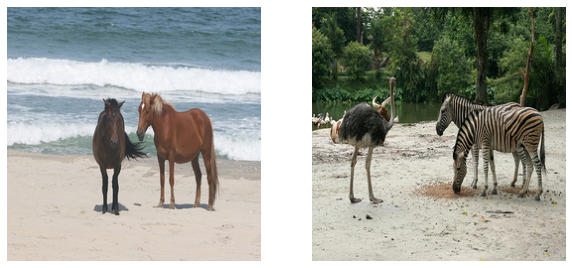

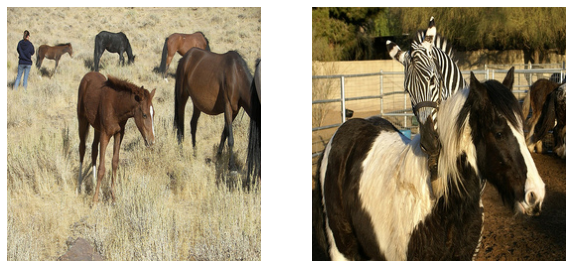

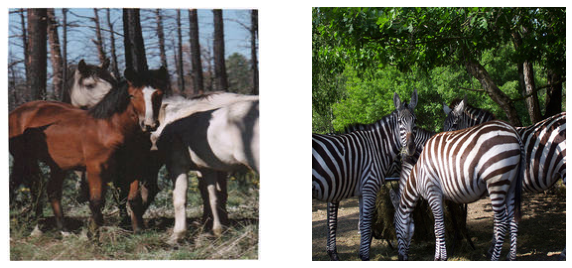

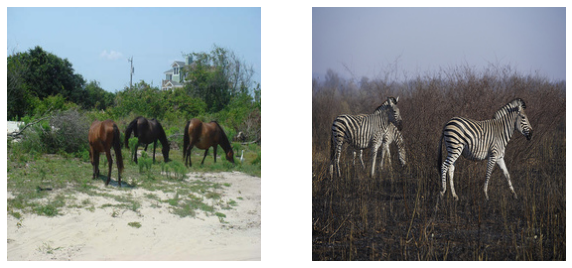

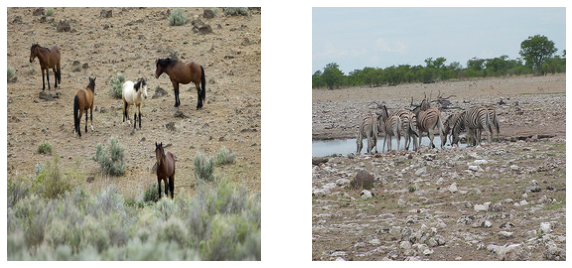

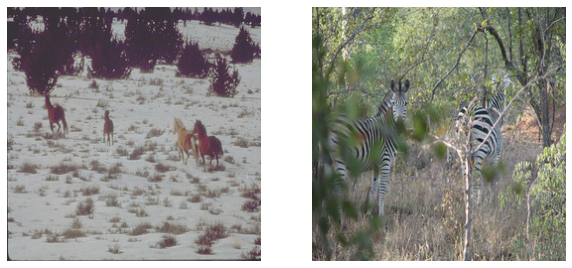

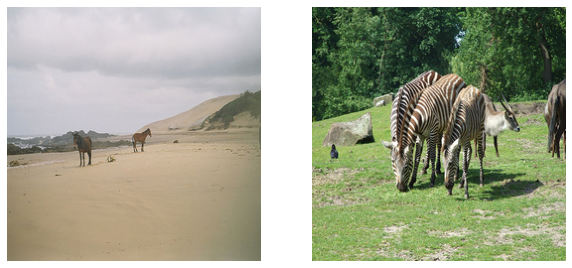

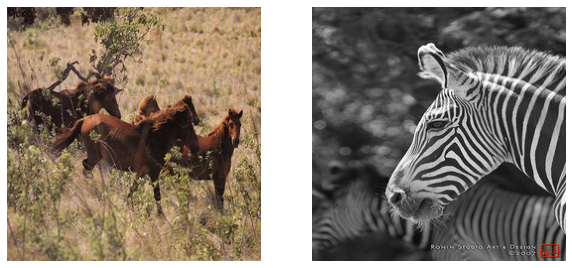

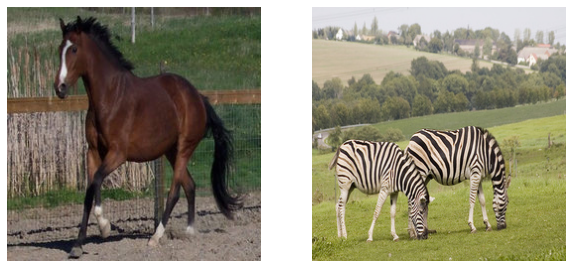

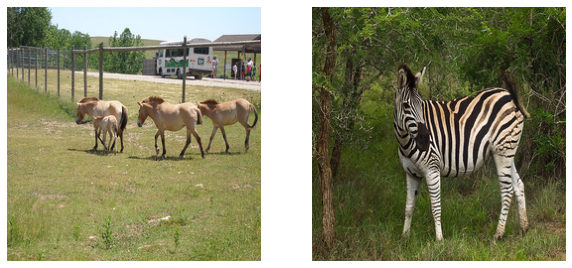

In [12]:
# Visualizing
for i in range(10):
    id = np.random.randint(len(horse_images))
    horse, zebra = horse_images[id], zebra_images[id]
    
    plt.figure(figsize=(10,8))
    
    plt.subplot(1,2,1)
    show_image(horse)
    
    plt.subplot(1,2,2)
    show_image(zebra)
    plt.show()

As you can easily notice, there is **no direct relation** between **horses and zebras** with respect to the images we are going to feed into the model. So somehow the model will have to understand the **actual important information** about **horses and zebras**, and at the same time it should also learn to **transform a horse to a zebra or zebra to a horse**. 

# **Generator**

The **overall generator** is the same as the **previous generator** used in **pixel to pixel GAN**, but this time the generator has a **New Residual block**. Let's create this **Residual Block**, this **residual block** has the **2 set** **Convolutional layer** followed by **instance normalization**, which is in last followed by a **Skip Connection**.

In [14]:
def ResidualBlock(filters, layer, index):
#     init = RandomNormal(stddev=0.02)
    
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, name="Block_{}_Conv1".format(index))(layer)
    x = InstanceNormalization(axis=-1, name="Block_{}_Normalization1".format(index))(x)
    x = ReLU(name="Block_{}_ReLU".format(index))(x)
    
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, name="Block_{}_Conv2".format(index))(x)
    x = InstanceNormalization(axis=-1, name="Block_{}_Normalization2".format(index))(x)
    
    x = concatenate([x, layer], name="Block_{}_Merge".format(index))
    
    return x

The **residual network** uses a **stride = 1**. That means it does **not decreases** the **size of the input image**. All it does is it **learns the features of the image**.

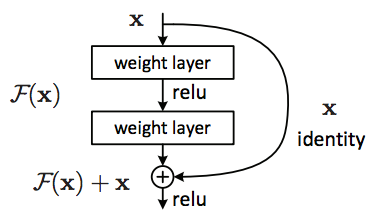

Let's create the **main model architecture**.

In [15]:
def downsample(filters, layer, size=3, strides=2, activation=None, index=None, norm=True):
    x = Conv2D(filters, kernel_size=size, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False, name="Encoder_{}_Conv".format(index))(layer)
    if norm:
        x = InstanceNormalization(axis=-1, name="Encoder_{}_Normalization".format(index))(x)
    if activation is not None:
        x = Activation(activation, name="Encoder_{}_Activation".format(index))(x)
    else:
        x = LeakyReLU( name="Encoder_{}_LeakyReLU".format(index))(x)
    return x

The **downsample layer**, will simply **decrease the size of the input image by 2**.

In [17]:
def upsample(filters, layer, size=3, strides=2, index=None):
    x = Conv2DTranspose(filters, kernel_size=size, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False, name="Decoder_{}_ConvT".format(index))(layer)
    x = InstanceNormalization(axis=-1, name="Decoder_{}_Normalization".format(index))(x)
    x = ReLU(name="Encoder_{}_ReLU".format(index))(x)
    return x

**Upsample** will perform the **exact opposite** and will **increase the image size by 2**.

In [19]:
def Generator(n_resnet=9, name="Generator"):
    
    inp_image = Input(shape=(SIZE, SIZE, 3), name="InputImage")         # 256 x 256 x3
    
    x = downsample(64, inp_image, size=7, strides=1, index=1)           # 256 x 256 x 64
    x = downsample(128, x, index=2)                                     # 128 x 128 x 128
    x = downsample(256, x, index=3)                                     # 64 x 64 x 256
    
    for i in range(n_resnet):
        x = ResidualBlock(256, x, index=i+4)                             # (64 x 64 x 256) x n_resnet
    
    x = upsample(128, x, index=13)                                       # 128 x 128 x 128
    x = upsample(64, x, index=14)                                        # 256 x 256 x 64
    x = downsample(3, x, size=7, strides=1, activation='tanh', index=15) # 256 x 256 x 3
    
    model = Model(
        inputs=inp_image,
        outputs=x,
        name=name
    )
    return model

The **final generator** is basically the **combination of down sample layers**, **upsample layers** and most importantly the **residual block layers**. The main function of **residual block layers** is to actually learn the **hidden patterns in the data**. In our case, that means to learn **what a horse looks like** and **what a zebra looks like**. So our generator is ready, let's move towards the **discriminator**.

# **Discriminator**

As I mentioned, the **discriminator** is **exactly the same** as the one we have previously used in **pixel to pixel GAN**. The only thing we need to keep in mind is that instead of using **batch normalization**, we need to use **instance normalization**.

In [20]:
def Discriminator(name='Discriminator'):
    init = RandomNormal(stddev=0.02)
    src_img = Input(shape=(SIZE, SIZE, 3), name="InputImage")     # 256 x 256 x 3
    x = downsample(64, src_img, size=4, strides=2, index=1, norm=False) # 128 x 128 x 64
    x = downsample(128, x, size=4, strides=2, index=2)            # 64 x 64 x 128
    x = downsample(256, x, size=4, strides=2, index=3)            # 32 x 32 x 256
    x = downsample(512, x, size=4, strides=2, index=4)            # 16 x 16 x 512
    x = downsample(512, x, size=4, strides=2, index=5)            # 8 x 8 x 512  # we can try out a different architecture with zero padding layer.
    patch_out = Conv2D(1, kernel_size=4, padding='same', kernel_initializer=init, use_bias=False)(x) # 8 x 8 x 1
    
    model = Model(
        inputs=src_img,
        outputs=patch_out,
        name=name
    )
    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
        loss_weights=[0.5]
    )
    return model

The **main function** of **discriminator** is to actually learn whether the **generated images** are actually **generated from the input image** or not. That means the **spatial dimensions** of the **input image** and the **generated image** should be the same. While the information they contain **should be different**.

# **Training Functions**

In [21]:
def CombineModel(g_model1, g_model2, d_model, name):
    # train the Generator
    g_model1.trainable = True

    # Stop the Discriminator and 2nd Generator
    d_model.trainable = False
    g_model2.trainable = False
    
    # Adversarial Loss
    input_gen = Input(shape=(SIZE, SIZE, 3))
    gen_1_out = g_model1(input_gen)
    dis_out = d_model(gen_1_out)
    
    # Identity Loss
    input_id = Input(shape=(SIZE, SIZE, 3))
    output_id = g_model1(input_id)
    
    # Cycle Loss - Forward
    output_f = g_model2(gen_1_out)
    
    # Cycle Loss - Backward
    gen_2_out = g_model2(input_id)
    output_b = g_model1(gen_2_out)
    
    # Final Model 
    model = Model(
        inputs=[input_gen, input_id],
        outputs=[dis_out, output_id, output_f, output_b],
        name=name
    )
    model.compile(
        loss=['mse', 'mae', 'mae', 'mae'],
        loss_weights=[1,5,10,10],
        optimizer= Adam(learning_rate=2e-4, beta_1=0.5)
    )
    return model

As you can see that this **combined model function** simply takes in the **generator** and the **discriminator** and combine them. To make a **single model**, This will help us during the **training process**.

In [22]:
def generate_real_samples(n_samples, dataset):
    ix = np.random.randint(0,dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones(shape=(n_samples, 8, 8, 1))
    return X, y

In [23]:
def generate_fake_samples(g_model, dataset):
    X = g_model.predict(dataset)
    y = np.zeros(shape=(len(dataset), 8, 8, 1))
    return X, y

All these functions are self-explanatory.

In [24]:
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            selected.append(image)
        else:
            ix = np.random.randint(0,len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)

Actually, the **authors** created a pool of **50 images**. So they don't just feed the **current image** to the **discriminator and the generator**, but they actually feed the **pool of images**. That's why we have created this pool. 

In [25]:
def show_preds(g_AB, g_BA,n_images=1):
    for i in range(n_images):
        
        id = np.random.randint(len(horse_images))
        horse, zebra = horse_images[id], zebra_images[id]
        horse_pred, zebra_pred = g_BA.predict(tf.expand_dims(zebra,axis=0))[0], g_AB.predict(tf.expand_dims(horse,axis=0))[0]
        
        plt.figure(figsize=(10,8))
        
        plt.subplot(1,4,1)
        show_image(horse, title='Original Horse')
        
        plt.subplot(1,4,2)
        show_image(zebra_pred, title='Generated Zebra')
        
        plt.subplot(1,4,3)
        show_image(zebra, title='Original Zebra')
        
        plt.subplot(1,4,4)
        show_image(horse_pred, title='Genrated Horse')
        
        plt.tight_layout()
        plt.show()

In [26]:
def train(d_model_A, d_model_B, gen_AB, gen_BA, c_AB, c_BA, epochs=10, chunk=5):
    
    n_epochs, n_batch = epochs, 1
    
    trainA, trainB = dataset
    poolA, poolB = list(), list()
    
    # in simple words, we are going through the whole data.
    bat_per_epoch = int(len(trainA)/n_batch)
    n_steps = bat_per_epoch
    
    for j in tqdm(range(1,epochs+1), desc="Epochs"):
        for i in range(n_steps):
            
            # Let's get some real data in hand.
            X_realA, y_realA = generate_real_samples(n_batch, trainA)
            X_realB, y_realB = generate_real_samples(n_batch, trainB)

            # use our generators to generate some fake data.
            X_fakeA, y_fakeA = generate_fake_samples(gen_BA, X_realB)
            X_fakeB, y_fakeB = generate_fake_samples(gen_AB, X_realA)
            
            # create a pool of images. You can also understand it like a replay buffer.
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolA, X_fakeB)
            
            
            # Let's finally train the gen 2 and get the losses.
            gen_loss2, _, _, _, _ = c_BA.train_on_batch(
                [X_realB, X_realA],
                [y_realB, X_realA, X_realB, X_realA]
            )
            
            # It's time for our discriminator to win our generator.
            dA_loss_1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss_2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
            
            # one cycle is completed, let's move to second cycle.
            gen_loss1, _, _, _, _ = c_AB.train_on_batch(
                [X_realA, X_realB],
                [y_realA, X_realB, X_realA, X_realB]
            )
            
            # again, let's give some power to our discriminators.
            dB_loss_1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss_2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

        if (j%chunk)==0:
            show_preds(gen_AB, gen_BA, n_images=1)
            gen_AB.save("GeneratorHtoZ.h5")
            gen_BA.save("GeneratorZtoH.h5")

# **Training**

In [28]:
# let's create our generators.
g_AB = Generator(name="GeneratorAB")
g_BA = Generator(name="GeneratorBA")

# here are the respective discriminators.
d_A = Discriminator(name="DiscriminatorA")
d_B = Discriminator(name="DiscriminatorB")

# finally, let's combine all of them.
c_AB = CombineModel(g_AB, g_BA, d_B, name="GanAB")
c_BA = CombineModel(g_BA, g_AB, d_A, name="GanBA")

In [ ]:
# # it's time to give them the superior knowledge.
# train(d_A, d_B, g_AB, g_BA, c_AB, c_BA, epochs=100, chunk=5)

In [ ]:
# g_AB.save("GeneratorHtoZ.h5")
# g_BA.save("GeneratorZtoH.h5")

Model After **25 Epochs** $:$

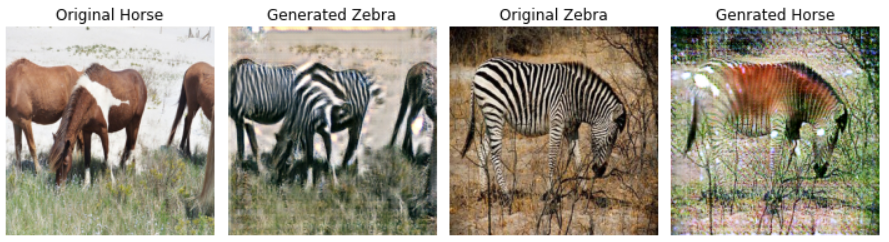

# **Evaluation**

In [29]:
HtoZ_gen = load_model("../input/imagetoimage-translation-cyclegan/GeneratorHtoZ.h5")
ZtoH_gen = load_model("../input/imagetoimage-translation-cyclegan/GeneratorZtoH.h5")

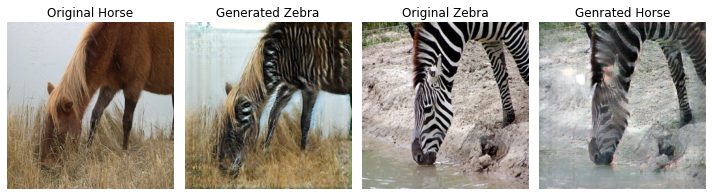

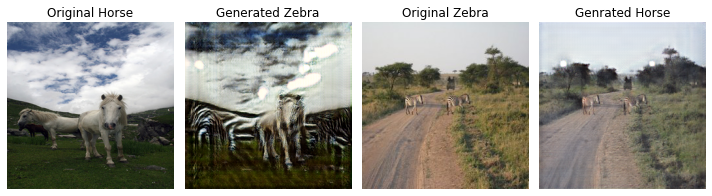

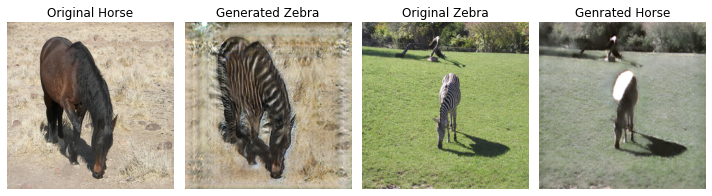

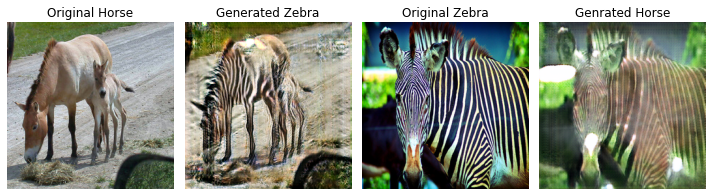

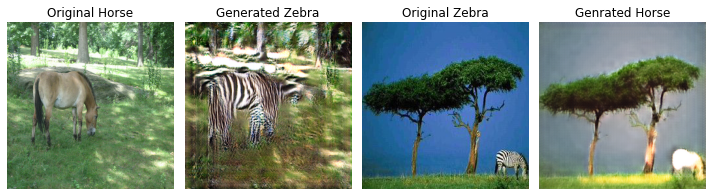

In [30]:
show_preds(HtoZ_gen, ZtoH_gen, n_images=5)

In [31]:
HtoZ_gen_25 = load_model("../input/imagetoimage-translation-cyclegan/GeneratorHtoZ_25.h5")
ZtoH_gen_25 = load_model("../input/imagetoimage-translation-cyclegan/GeneratorZtoH_25.h5")

These are the model weights of 25th epoch. Which I found to be the best model in terms of horse to zebra generator.

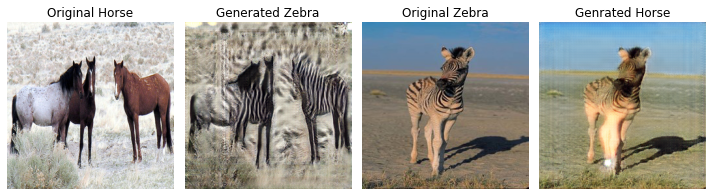

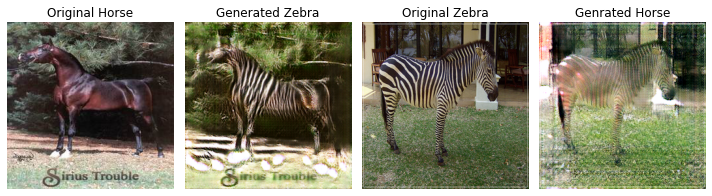

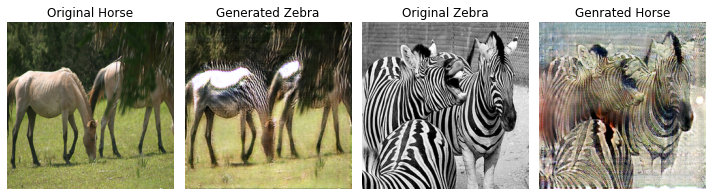

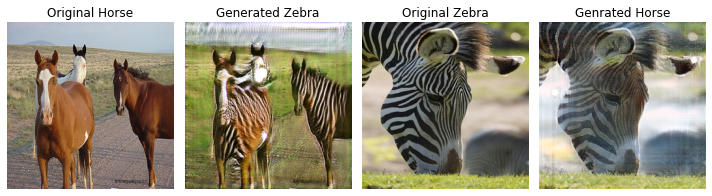

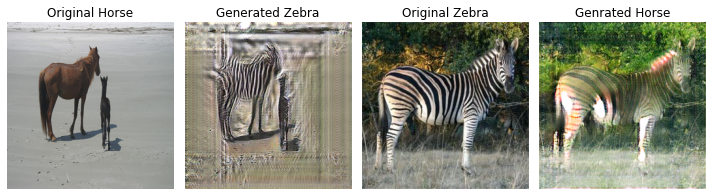

In [32]:
show_preds(HtoZ_gen_25, ZtoH_gen_25, n_images=5)

$Observations :$

* The **zebra to horse Generator** was amazing at the time of initial training. It is performing bad now. This could be the result of **unstable training**.

* The **horse generator** is still trying to just **color out the zebra,** and it's pretty bad at it.

* The **horse to Zebra generator** is good, at least it's performing something, but it **loses a lot of spatial information** during transformation.

* The **25th Epoch Horse to Zebra generator** is somehow better than the other **Horse to Zebra generator**.

* The good thing is that the first generator has **not only learned to change the color, but also to add scales**.

---
The models are not perfect yet. They are just trained for 25 epochs. Which took around 12 hours.
These images shows the potential of **cycle GAN**. By enough training, **cycle GAN** could be perfect.

---

